In [1]:
%pdb on

Automatic pdb calling has been turned ON


In [2]:
import numpy as np
import tensorflow as tf
import sys
import os
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
if os.path.abspath('../../tt_keras') not in sys.path:
    sys.path.append(os.path.abspath('../../tt_keras'))

if os.path.abspath('../../t3f') not in sys.path:
    sys.path.append(os.path.abspath('../../t3f'))

import automatic_speech_recognition as asr
import time

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## Reference model and scripts

In [4]:
def get_pipeline(model):
    alphabet = asr.text.Alphabet(lang='en')
    features_extractor = asr.features.MFCC_legacy(
        features_num=26,
        standardize=False,
        winlen=0.032,
        winstep=0.02,
    )
    optimizer = tf.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
    decoder = asr.decoder.GreedyDecoder()
    pipeline = asr.pipeline.CTCPipeline(
        alphabet, features_extractor, model, optimizer, decoder
    )
    callbacks = []
    return pipeline

In [5]:
from transform_model import transform

In [6]:
from tt_dense_layer import TTDense
from tt_recurrent_layer import SimpleTTRNNCell, TTLSTMCell, FusedTTLSTMCell
custom_objects = {'TTDense': TTDense, 'SimpleTTRNNCell': SimpleTTRNNCell, 'TTLSTMCell': TTLSTMCell, 'FusedTTLSTMCell': FusedTTLSTMCell}

In [7]:
def get_accuracy_by_rank(test_ds, models_filename_template, ranks):
    wers = []
    cers = []
    for rank in tqdm(ranks):
        model_filename = models_filename_template.format(rank)
        tt_model = tf.keras.models.load_model(model_filename, custom_objects=custom_objects)
        pipeline = get_pipeline(tt_model)
        wer, cer = asr.evaluate.calculate_error_rates(pipeline, test_ds, print_pred=False)
        wers.append(wer)
        cers.append(cer)
    return np.array(ranks), np.array(wers), np.array(cers)

In [8]:
# build the models
model = asr.model.load_mozilla_deepspeech('./data/mozilla_deepspeech.pb', tflite_version=False, is_mixed_precision=False)

load graph
Instructions for updating:
Use tf.gfile.GFile.
['IteratorV2', 'IteratorGetNext', 'Shape', 'strided_slice/stack', 'strided_slice/stack_1', 'strided_slice/stack_2', 'strided_slice', 'Const', 'conv1d/ExpandDims/dim', 'conv1d/ExpandDims', 'conv1d/ExpandDims_1/dim', 'conv1d/ExpandDims_1', 'conv1d', 'conv1d/Squeeze', 'Reshape/shape/1', 'Reshape/shape/2', 'Reshape/shape/3', 'Reshape/shape', 'Reshape', 'transpose/perm', 'transpose', 'Reshape_1/shape', 'Reshape_1', 'layer_1/bias', 'layer_1/bias/read', 'layer_1/weights', 'layer_1/weights/read', 'MatMul', 'BiasAdd', 'Relu', 'Minimum/y', 'Minimum', 'StringFormat', 'PrintV2', 'Identity', 'layer_2/bias', 'layer_2/bias/read', 'layer_2/weights', 'layer_2/weights/read', 'MatMul_1', 'BiasAdd_1', 'Relu_1', 'Minimum_1/y', 'Minimum_1', 'layer_3/bias', 'layer_3/bias/read', 'layer_3/weights', 'layer_3/weights/read', 'MatMul_2', 'BiasAdd_2', 'Relu_2', 'Minimum_2/y', 'Minimum_2', 'Reshape_2/shape', 'Reshape_2', 'cudnn_lstm/rnn/multi_rnn_cell/cell_0/

In [24]:
model.save('./models/ds.h5')

In [10]:
### Reference accuracy

In [14]:
pipeline_ref = get_pipeline(model)

In [15]:
dev_dataset = asr.dataset.Audio.from_csv('./data/dev-clean-index.csv', batch_size=32)

In [16]:
tim = time.time()
wer_ref, cer_ref = asr.evaluate.calculate_error_rates(pipeline_ref, dev_dataset)
print(f"Elapsed: {time.time() - tim}")
print(f"WER: {wer_ref}, CER: {cer_ref}")

Elapsed: 366.74937748908997
WER: 0.13360058612399023, CER: 0.041848369145504376


## Sensitivity test

In [9]:
tt_ranks = np.arange(2, 1024, 60)
shape = ((16, 2, 2, 2, 16), (16, 2, 2, 2, 16))

In [10]:
dev_dataset = asr.dataset.Audio.from_csv('./data/dev-clean-index.csv', batch_size=32)

In [11]:
def replace_dense2(model, shape, rank):
    replacement_config = {
        'td_dense_2': {
            'config': {
                'name': 'tt_dense_2',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': rank,
            },
            'init': {
                'max_tt_rank': rank,
                'epsilon': 0.0
            }
        },
    }
  
    new_model = transform(model, replacement_config, from_layer=6)
    new_model.trainable = True
     
    return new_model


def replace_dense3(model, shape, rank):
    replacement_config = {
        'td_dense_3': {
            'config': {
                'name': 'tt_dense_3',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': rank,
            },
            'init': {
                'max_tt_rank': rank,
                'epsilon': 0.0
            }
        },
    }
  
    new_model = transform(model, replacement_config, from_layer=6)
    new_model.trainable = True
     
    return new_model


def replace_lstm(model, shape, lstm_rank, lstm_r_rank):
    replacement_config = {
        'lstm': {
            'cell_type': 'FusedTTLSTMCell',
            'config': {
                'name': 'tt_fusedlstm_0',
                'input_dims': shape[0],
                'output_dims': shape[1],
                'tt_rank': lstm_rank,
                'recurrent_tt_rank': lstm_r_rank,
            },
            'init': {
                'kernel': {
                    'max_tt_rank': lstm_rank,
                    'epsilon': 0.0
                },
                'recurrent': {
                    'max_tt_rank': lstm_r_rank,
                    'epsilon': 0.0
                }
            }
        },
    }
  
    new_model = transform(model, replacement_config, from_layer=6)
    new_model.trainable = True
     
    return new_model


def replace_dense4(model, shape, rank):
    replacement_config = {
        'td_dense_4': {
            'config': {
                'name': 'tt_dense_4',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': rank,
            },
            'init': {
                'max_tt_rank': rank,
                'epsilon': 0.0
            }
        },
    }
  
    new_model = transform(model, replacement_config, from_layer=6)
    new_model.trainable = True
     
    return new_model

In [23]:
for rank in tqdm(tt_ranks):
    tt_model = replace_dense2(model, shape, rank)
    filename = f'./models/ds_sensitivity/ds_dense2_r{rank}.h5'
    tt_model.save(filename, save_format='h5')

100%|██████████| 18/18 [03:06<00:00, 10.38s/it]


In [17]:
for rank in tqdm(tt_ranks):
    tt_model = replace_dense3(model, shape, rank)
    filename = f'./models/ds_sensitivity/ds_dense3_r{rank}.h5'
    tt_model.save(filename, save_format='h5')

100%|██████████| 18/18 [09:01<00:00, 30.07s/it]


In [ ]:
for rank in tqdm(tt_ranks):
    tt_model = replace_lstm(model, shape, rank, rank)
    filename = f'./models/ds_sensitivity/ds_lstm_r{rank}.h5'
    tt_model.save(filename, save_format='h5')

In [19]:
for rank in tqdm(tt_ranks):
    tt_model = replace_dense4(model, shape, rank)
    filename = f'./models/ds_sensitivity/ds_dense4_r{rank}.h5'
    tt_model.save(filename, save_format='h5')

100%|██████████| 18/18 [08:56<00:00, 29.80s/it]


In [ ]:
####

In [23]:
wer_d2, cer_d2 = [], []
for rank in tqdm(tt_ranks):
    tt_model = tf.keras.models.load_model(
        f'./models/ds_sensitivity/ds_dense2_r{rank}.h5',
        custom_objects=custom_objects)
    pipeline = get_pipeline(tt_model)
    wer, cer = asr.evaluate.calculate_error_rates(pipeline, dev_dataset)
    wer_d2.append(wer)
    cer_d2.append(cer)
np.savez(f'./data/ds_sensitivity/ds_dense2.npz', wer=wer_d2, cer=cer_d2, ranks=tt_ranks)

  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [02:20<39:53, 140.78s/it]

 11%|█         | 2/18 [06:09<44:34, 167.14s/it]

 17%|█▋        | 3/18 [11:34<53:39, 214.65s/it]

 22%|██▏       | 4/18 [19:53<1:09:57, 299.79s/it]

 28%|██▊       | 5/18 [31:55<1:32:22, 426.36s/it]

 33%|███▎      | 6/18 [46:34<1:52:28, 562.38s/it]

 39%|███▉      | 7/18 [1:04:34<2:11:34, 717.66s/it]

 44%|████▍     | 8/18 [1:25:28<2:26:23, 878.37s/it]

 50%|█████     | 9/18 [1:50:02<2:38:35, 1057.29s/it]

 56%|█████▌    | 10/18 [2:19:54<2:50:20, 1277.54s/it]

 61%|██████    | 11/18 [2:54:32<2:57:04, 1517.78s/it]

 67%|██████▋   | 12/18 [3:34:37<2:58:23, 1783.89s/it]

 72%|███████▏  | 13/18 [4:21:30<2:54:22, 2092.49s/it]

 78%|███████▊  | 14/18 [5:16:21<2:43:28, 2452.20s/it]

 83%|████████▎ | 15/18 [6:12:36<2:16:26, 2728.95s/it]

 89%|████████▉ | 16/18 [7:19:52<1:44:02, 3121.01s/it]

 94%|█████████▍| 17/18 [8:36:00<59:15, 3555.25s/it]  

100%|██████████| 18/18 [9:47:15<00:00, 1957.55s/it]


In [ ]:
wer_d3, cer_d3 = [], []
for rank in tqdm(tt_ranks):
    tt_model = tf.keras.models.load_model(
        f'./models/ds_sensitivity/ds_dense3_r{rank}.h5',
        custom_objects=custom_objects)
    pipeline = get_pipeline(tt_model)
    wer, cer = asr.evaluate.calculate_error_rates(pipeline, dev_dataset)
    wer_d3.append(wer)
    cer_d3.append(cer)
np.savez(f'./data/ds_sensitivity/ds_dense3.npz', wer=wer_d3, cer=cer_d3, ranks=tt_ranks)

  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [03:34<1:00:48, 214.59s/it]

 11%|█         | 2/18 [07:28<58:47, 220.45s/it]  

 17%|█▋        | 3/18 [12:58<1:03:17, 253.14s/it]

 22%|██▏       | 4/18 [21:18<1:16:23, 327.39s/it]

 28%|██▊       | 5/18 [33:24<1:36:51, 447.00s/it]

 33%|███▎      | 6/18 [48:09<1:55:39, 578.27s/it]

 39%|███▉      | 7/18 [1:06:05<2:13:24, 727.66s/it]

 44%|████▍     | 8/18 [1:27:05<2:27:53, 887.39s/it]

 50%|█████     | 9/18 [1:51:46<2:39:47, 1065.24s/it]

 56%|█████▌    | 10/18 [2:21:01<2:49:38, 1272.29s/it]

 67%|██████▋   | 12/18 [3:31:34<2:51:23, 1713.89s/it]

 72%|███████▏  | 13/18 [4:15:47<2:46:18, 1995.67s/it]

 78%|███████▊  | 14/18 [5:08:09<2:35:57, 2339.42s/it]

In [13]:
wer_lstm = list(np.load(f'./data/ds_sensitivity/ds_lstm.npz')['wer'])
cer_lstm = list(np.load(f'./data/ds_sensitivity/ds_lstm.npz')['cer'])

In [14]:
len(wer_lstm)

8

In [ ]:
#wer_lstm, cer_lstm = [], []
for rank in tqdm(tt_ranks[9:11]):
    tt_model = tf.keras.models.load_model(
        f'./models/ds_sensitivity/ds_lstm_r{rank}.h5',
        custom_objects=custom_objects)
    pipeline = get_pipeline(tt_model)
    wer, cer = asr.evaluate.calculate_error_rates(pipeline, dev_dataset)
    wer_lstm.append(wer)
    cer_lstm.append(cer)
np.savez(f'./data/ds_sensitivity/ds_lstm.npz', wer=wer_lstm, cer=cer_lstm, ranks=tt_ranks)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
wer_d4, cer_d4 = [], []
for rank in tqdm(tt_ranks):
    tt_model = tf.keras.models.load_model(
        f'./models/ds_sensitivity/ds_dense4_r{rank}.h5',
        custom_objects=custom_objects)
    pipeline = get_pipeline(tt_model)
    wer, cer = asr.evaluate.calculate_error_rates(pipeline, dev_dataset)
    wer_d4.append(wer)
    cer_d4.append(cer)
np.savez(f'./data/ds_sensitivity/ds_dense4.npz', wer=wer_d4, cer=cer_d4, ranks=tt_ranks)

  0%|          | 0/18 [00:00<?, ?it/s]

  6%|▌         | 1/18 [03:32<1:00:15, 212.70s/it]

In [11]:
wers, cers, ranks = (np.load(f'./data/ds_sensitivity/ds_dense2.npz')['wer'],
                     np.load(f'./data/ds_sensitivity/ds_dense2.npz')['cer'],
                     np.load(f'./data/ds_sensitivity/ds_dense2.npz')['ranks'])

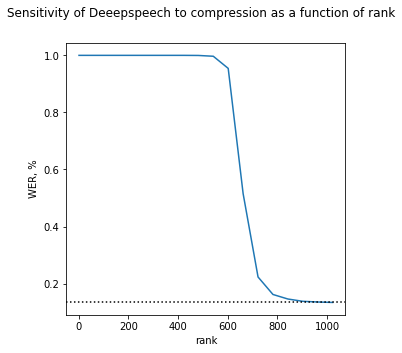

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(ranks, wers, label='wer')
# r, acc_ref - acc_direct
ax.axhline(wer_ref, ls=':', label='reference', c='k')
ax.set_xlabel('rank')
ax.set_ylabel('WER, %')

fig.suptitle('Sensitivity of Deeepspeech to compression as a function of rank')
fig.savefig('sense.png')

In [16]:
wers, cers, ranks = (np.load(f'./data/ds_sensitivity/ds_dense3.npz')['wer'],
                     np.load(f'./data/ds_sensitivity/ds_dense3.npz')['cer'],
                     np.load(f'./data/ds_sensitivity/ds_dense3.npz')['ranks'])

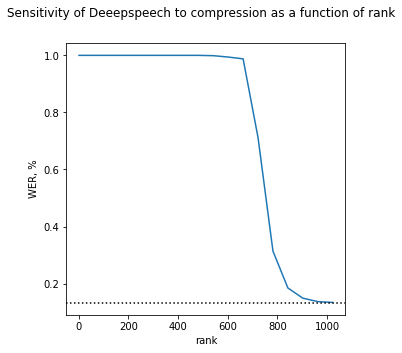

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(ranks, wers, label='wer')
# r, acc_ref - acc_direct
ax.axhline(wer_ref, ls=':', label='reference', c='k')
ax.set_xlabel('rank')
ax.set_ylabel('WER, %')

fig.suptitle('Sensitivity of Deeepspeech to compression as a function of rank')
fig.savefig('sense.png')

In [14]:
wers, cers, ranks = (np.load(f'./data/ds_sensitivity/ds_dense4.npz')['wer'],
                     np.load(f'./data/ds_sensitivity/ds_dense4.npz')['cer'],
                     np.load(f'./data/ds_sensitivity/ds_dense4.npz')['ranks'])

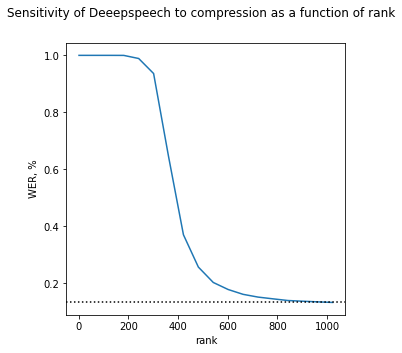

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(ranks, wers, label='wer')
# r, acc_ref - acc_direct
ax.axhline(wer_ref, ls=':', label='reference', c='k')
ax.set_xlabel('rank')
ax.set_ylabel('WER, %')

fig.suptitle('Sensitivity of Deeepspeech to compression as a function of rank')
fig.savefig('sense.png')

In [14]:
wers, cers, ranks = (np.load(f'./data/ds_sensitivity/ds_lstm.npz')['wer'],
                     np.load(f'./data/ds_sensitivity/ds_lstm.npz')['cer'],
                     np.load(f'./data/ds_sensitivity/ds_lstm.npz')['ranks'])
ranks = ranks[:9]

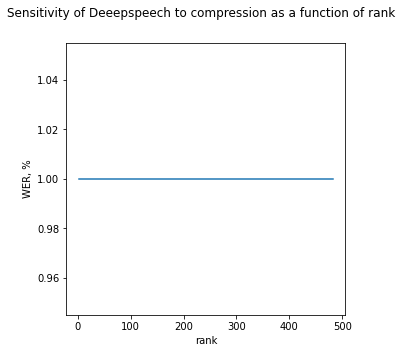

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(ranks, wers, label='wer')
# r, acc_ref - acc_direct
#ax.axhline(wer_ref, ls=':', label='reference', c='k')
ax.set_xlabel('rank')
ax.set_ylabel('WER, %')

fig.suptitle('Sensitivity of Deeepspeech to compression as a function of rank')
fig.savefig('sense.png')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(ranks, wers, label='wer')
# r, acc_ref - acc_direct
#ax.axhline(wer_ref, ls=':', label='reference', c='k')
ax.set_xlabel('rank')
ax.set_ylabel('WER, %')

fig.suptitle('Sensitivity of Deeepspeech to compression as a function of rank')
fig.savefig('sense.png')

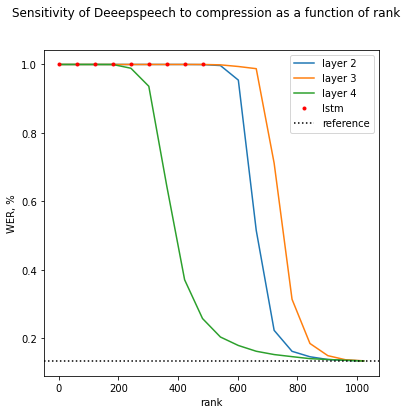

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for ii in range(2, 5):
    wers, cers, ranks = (np.load(f'./data/ds_sensitivity/ds_dense{ii}.npz')['wer'],
                         np.load(f'./data/ds_sensitivity/ds_dense{ii}.npz')['cer'],
                         np.load(f'./data/ds_sensitivity/ds_dense{ii}.npz')['ranks'])
    ax.plot(ranks, wers, label=f'layer {ii}')
# r, acc_ref - acc_direct
wers, cers, ranks = (np.load(f'./data/ds_sensitivity/ds_lstm.npz')['wer'],
                     np.load(f'./data/ds_sensitivity/ds_lstm.npz')['cer'],
                     np.load(f'./data/ds_sensitivity/ds_lstm.npz')['ranks'])
ranks = ranks[:len(wers)]
ax.plot(ranks, wers, 'r.', label=f'lstm')

ax.axhline(wer_ref, ls=':', label='reference', c='k')
ax.set_xlabel('rank')
ax.set_ylabel('WER, %')
ax.legend()

fig.suptitle('Sensitivity of Deeepspeech to compression as a function of rank')
fig.savefig('sense.png')

9

## Accuracy with initializing all dense layers but tuning LSTM

In [28]:
tt_ranks = np.arange(2, 32, 1)
shape = ((16, 2, 2, 2, 16), (16, 2, 2, 2, 16))

In [30]:
dev_dataset = asr.dataset.Audio.from_csv('./data/dev-clean-index.csv', batch_size=8, use_filesizes=True)

In [ ]:
def get_tt_model_initdense(model, shape, dense_ranks, lstm_rank, lstm_r_rank):
    replacement_config = {
        'dense_2': {
            'config': {
                'name': 'tt_dense_2',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[0],
            },
        },
       'dense_3': {
            'config': {
                'name': 'tt_dense_3',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[1],
            },
        },
        'lstm': {
            'cell_type': 'FusedTTLSTMCell',
            'config': {
                'name': 'tt_fusedlstm_0',
                'input_dims': shape[0],
                'output_dims': shape[1],
                'tt_rank': lstm_rank,
                'recurrent_tt_rank': lstm_r_rank,
            },
            'init': {
                'kernel': {
                    'max_tt_rank': lstm_rank,
                    'epsilon': 0.0
                },
                'recurrent': {
                    'max_tt_rank': lstm_r_rank,
                    'epsilon': 0.0
                }
            }
        },
        'dense_4': {
            'config': {
                'name': 'tt_dense0',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[2],
            },
        },
    }
  
    new_model = transform(model, replacement_config, from_layer=8)
    new_model.trainable = True
     
    return new_model

In [20]:
for rank in tqdm(tt_ranks):
    tt_model = get_tt_model_initdense(model, shape, [rank, rank, rank], rank, rank)
    filename = f'./models/tt_ds_uniform_initdense_r{rank}.h5'
    tt_model.save(filename, save_format='h5')

In [ ]:
ranks, wers_initdense, cers_initdense = get_accuracy_by_rank(dev_dataset, './models/tt_ds_uniform_initdense_r{}.h5', tt_ranks)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(ranks, ref_time / times, label='speedup')
ax2 = ax.twinx()
ax2.plot(r, wer_ref - wers_initdense, ls='-', label='WER')
ax2.plot(r, cer_ref - cers_initdense, ls=':', label='CER')
# r, acc_ref - acc_direct
ax.set_xlabel('rank')
ax.set_ylabel('speedup')
ax2.set_ylabel('accuracy drop')

fig.suptitle('Network execution time and accuracy as function of rank')

## Accuracy with initializing all layers

In [24]:
tt_ranks = np.arange(2, 32, 1)
shape = ((16, 2, 2, 2, 16), (16, 2, 2, 2, 16))

In [25]:
dev_dataset = asr.dataset.Audio.from_csv('./data/dev-clean-index.csv', batch_size=8, use_filesizes=True, relative_paths=False)

In [26]:
def get_tt_model_initall(model, shape, dense_ranks, lstm_rank, lstm_r_rank):
    replacement_config = {
        'dense_2': {
            'config': {
                'name': 'tt_dense_2',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[0],
            },
        },
       'dense_3': {
            'config': {
                'name': 'tt_dense_3',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[1],
            },
        },
        'lstm': {
            'cell_type': 'FusedTTLSTMCell',
            'config': {
                'name': 'tt_fusedlstm_0',
                'input_dims': shape[0],
                'output_dims': shape[1],
                'tt_rank': lstm_rank,
                'recurrent_tt_rank': lstm_r_rank,
            },
        },
        'dense_4': {
            'config': {
                'name': 'tt_dense0',
                'input_dims': shape[0],
                'output_dims' : shape[1],
                'activation': 'linear',
                'tt_rank': dense_ranks[2],
            },
        },
    }
  
    new_model = transform(model, replacement_config, from_layer=8)
    new_model.trainable = True
     
    return new_model

In [27]:
for rank in tqdm(tt_ranks):
    tt_model = get_tt_model_initall(model, shape, [rank, rank, rank], rank, rank)
    filename = f'./models/tt_ds_uniform_initall_r{rank}.h5'
    tt_model.save(filename, save_format='h5')

In [ ]:
ranks, wers_initall, cers_initall = get_accuracy_by_rank(dev_dataset, './models/tt_ds_uniform_initdense_r{}.h5', tt_ranks)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(ranks, ref_time / times, label='speedup')
ax2 = ax.twinx()
ax2.plot(r, wer_ref - wers_initall, ls='-', label='WER')
ax2.plot(r, cer_ref - cers_initall, ls=':', label='CER')
# r, acc_ref - acc_direct
ax.set_xlabel('rank')
ax.set_ylabel('speedup')
ax2.set_ylabel('accuracy drop')

fig.suptitle('Network execution time and accuracy as function of rank')

2.048

array([[4.17022005e-01, 7.20324493e-01, 1.14374817e-04]])

(1, 3)